> Based on https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39

# Data loading and preprocessing

## Imports

In [7]:

import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
from pathlib import Path
from typing import Dict, List
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from functools import partial
import cv2
from PIL import Image
import torch
import torch.nn as nn
# import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
import warnings 
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
import joblib

print(device)

cuda


## Data loading

In [2]:
DATA_ROOT = "/mnt/e/Workspace/IDL/Data/project"
MODEL_ROOT = "/mnt/e/Workspace/IDL/Models/project/baseline"

EVAL = False

In [3]:
train = pd.read_csv(f'{DATA_ROOT}/hms-harmful-brain-activity-classification/train.csv')
TARGETS = train.columns[-6:] # vote classes
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['voter_count'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.


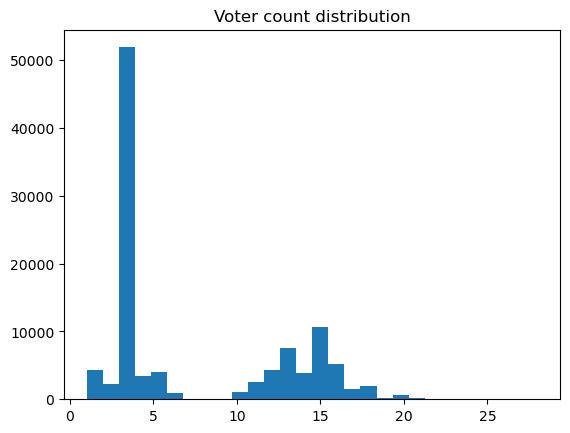

In [4]:
plt.hist(train['voter_count'], bins=train['voter_count'].max())
plt.title('Voter count distribution')
plt.show()

In [5]:
if not EVAL:
    spectrograms = np.load(f'{DATA_ROOT}/brain-spectrograms/specs.npy',allow_pickle=True).item()

In [8]:
if not EVAL:
    all_eegs = np.load(f'{DATA_ROOT}/eeg-spectrogram-by-lead-id-unique/eeg_specs.npy',allow_pickle=True).item()

In [ ]:
class EEGDataset(Dataset):
    def __init__(self, df, spectrograms, eegs, targets, transform=None):
        self.df = df
        self.spectrograms = spectrograms
        self.eegs = eegs
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        eeg_id = row.eeg_id
        spectrogram = self.spectrograms[eeg_id]
        eeg = self.eegs[eeg_id]
        if self.transform:
            eeg = self.transform(image=eeg)['image']
            spectrogram = self.transform(image=spectrogram)['image']
        target = torch.tensor(row[self.targets].values.astype(np.float32))
        return eeg, spectrogram, target